In [8]:
import numpy as np
import pandas as pd
import sys 
import os
sys.path.append(os.path.abspath("/ocean/projects/asc170022p/singla/Explanation_XRay"))
import yaml
from unet.SegmentationNetwork import UNET
import tensorflow as tf
from skimage.transform import resize
import matplotlib.pyplot as plt

# Config

In [9]:
main_dir = '/ocean/projects/asc170022p/singla/Explanation_XRay'
config_file = 'configs/JSRT_Segmentation_256.yaml'
config_path = os.path.join(main_dir, config_file)
config = yaml.load(open(config_path))

In [10]:
config

{'batch_size': 32,
 'ckpt_dir_continue': 'output/unet/JSRT_256/Lung',
 'count_to_save': 0,
 'crop_size': -1,
 'epochs': 50,
 'image_dir': '/ocean/projects/asc170022p/singla/Datasets/JSRT-Data',
 'img_column': 'input',
 'input_csv': '/ocean/projects/asc170022p/singla/Datasets/JSRT-Data/train.csv',
 'input_size': 256,
 'log_dir': 'output/unet/JSRT_256',
 'mask_column': 'Mask',
 'name': 'Lung',
 'names_to_save': '',
 'normalize': False,
 'num_channel': 1,
 'suffix': '',
 'test_csv': '/ocean/projects/asc170022p/singla/Datasets/JSRT-Data/validation.csv'}

# Model

In [11]:
x_source = tf.placeholder(tf.float32, [None, config['input_size'], config['input_size'], config['num_channel']])
x_mask = tf.placeholder(tf.float32, [None, config['input_size'], config['input_size'], config['num_channel']]) 
U = UNET() 
_, seg_x_source = U(x_source)



('x: ', <tf.Tensor 'Placeholder:0' shape=(?, 256, 256, 1) dtype=float32>)
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
('conv1: ', <tf.Tensor 'UNet/conv2d_1/Relu:0' shape=(?, 256, 256, 32) dtype=float32>)
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
('pool1: ', <tf.Tensor 'UNet/max_pooling2d/MaxPool:0' shape=(?, 128, 128, 32) dtype=float32>)
('conv2: ', <tf.Tensor 'UNet/conv2d_3/Relu:0' shape=(?, 128, 128, 64) dtype=float32>)
('pool2: ', <tf.Tensor 'UNet/max_pooling2d_1/MaxPool:0' shape=(?, 64, 64, 64) dtype=float32>)



In [12]:
ckpt_dir_continue = os.path.join(main_dir, config['ckpt_dir_continue'], 'ckpt_dir')
lst_vars = []
for v in tf.global_variables():
    lst_vars.append(v)
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
ckpt = tf.train.get_checkpoint_state(ckpt_dir_continue)      
ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
saver.restore(sess, os.path.join(ckpt_dir_continue, ckpt_name))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /ocean/projects/asc170022p/singla/Explanation_XRay/output/unet/JSRT_256/Lung/ckpt_dir/model50.ckpt


# Read Data

In [13]:
df = pd.read_csv(config['test_csv'], sep = ',')
print(df.shape)
df.head(2)

(75, 2)


input  \
0  All247images_New_512/JPCLN061.npy   
1  All247images_New_512/JPCLN025.npy   

                                                Mask  
0  Segmentation_512/Segmentation_Lung/JPCLN061_ms...  
1  Segmentation_512/Segmentation_Lung/JPCLN025_ms...

/ocean/projects/asc170022p/singla/anaconda/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/ocean/projects/asc170022p/singla/anaconda/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


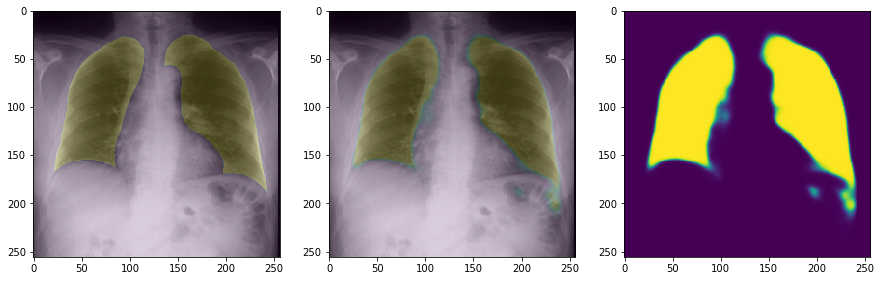

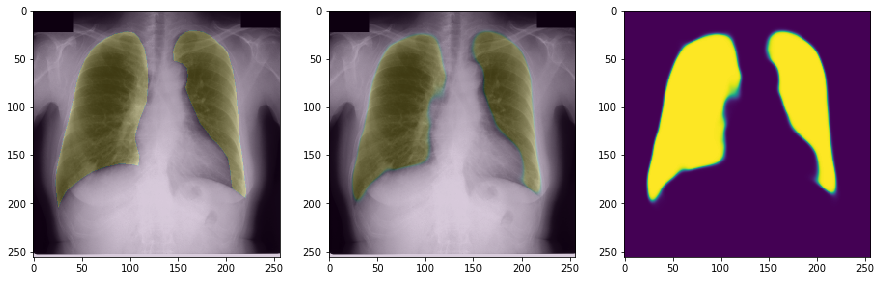

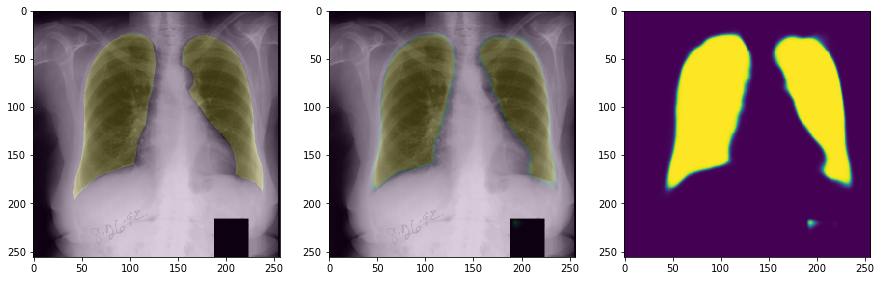

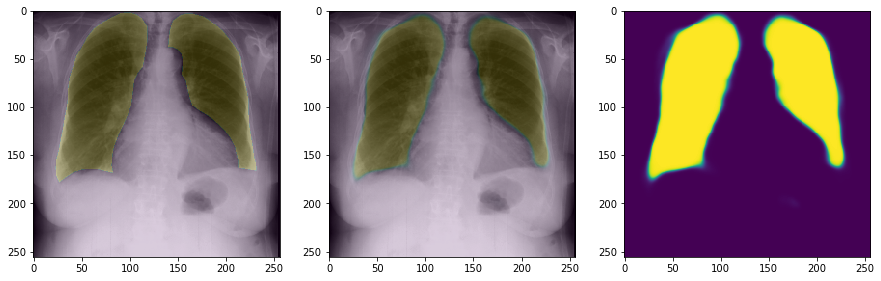

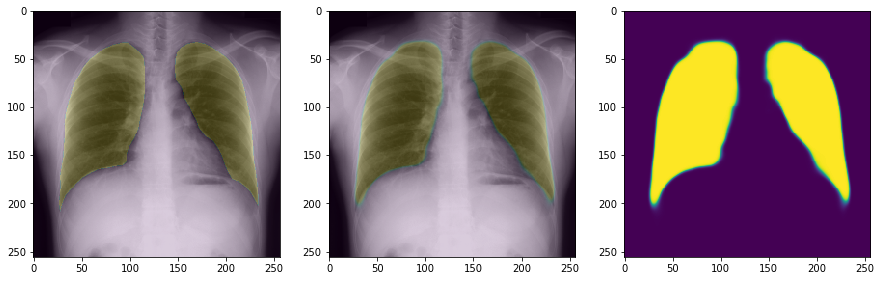

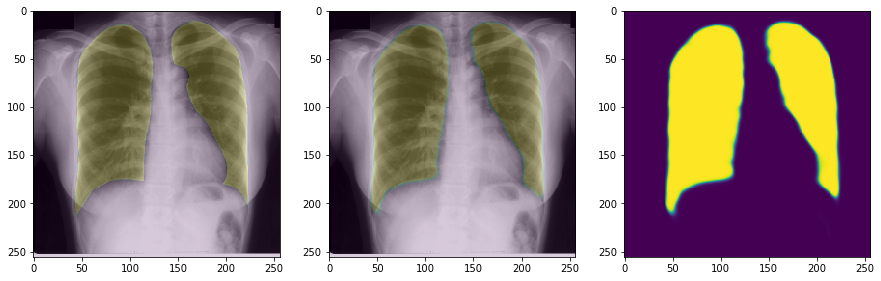

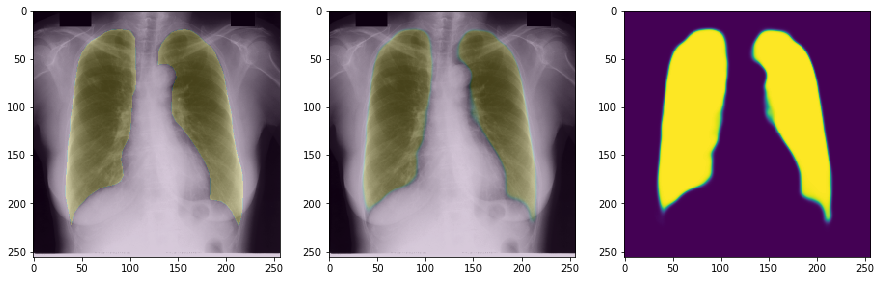

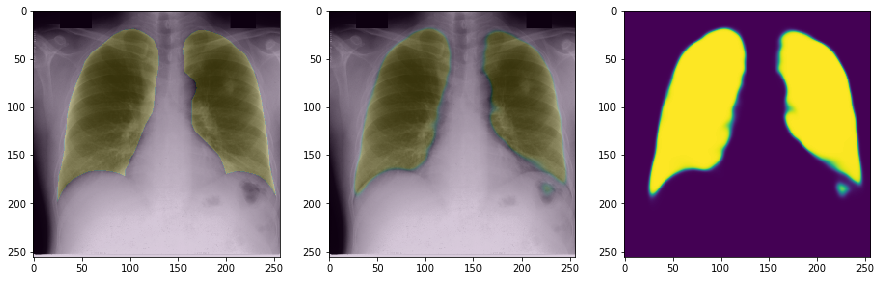

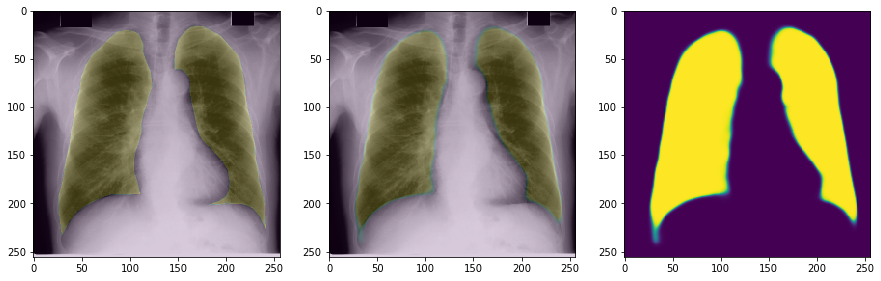

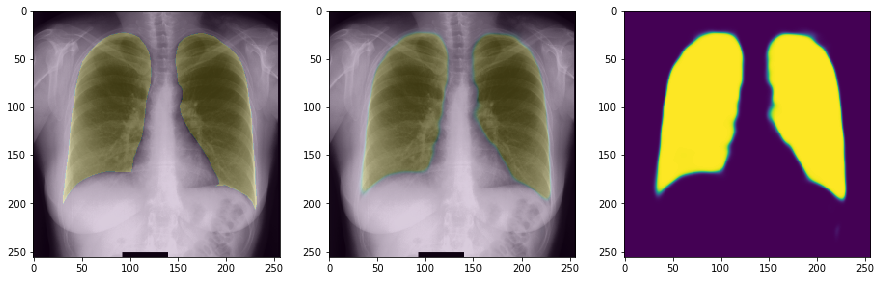

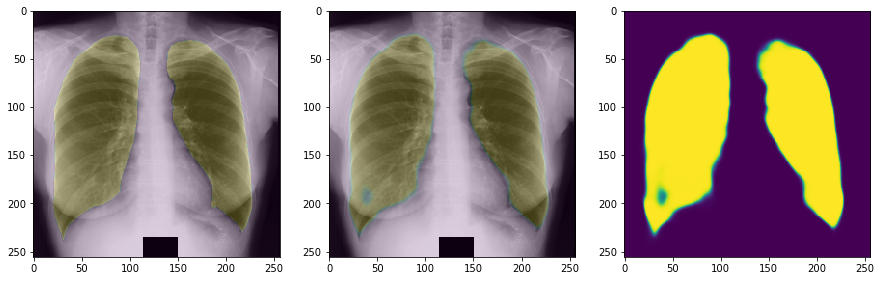

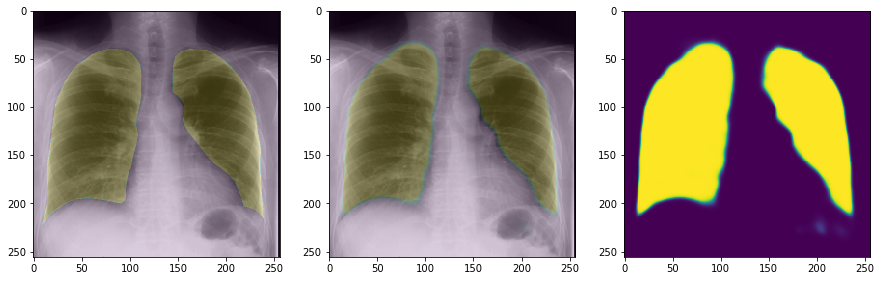

In [14]:
for index, row in df.iterrows():
    img = np.load(os.path.join(config['image_dir'],row['input']))
    img = resize(img, (config['input_size'], config['input_size']))
    img = np.expand_dims(img, 0)
    mask = np.load(os.path.join(config['image_dir'],row['Mask']))
    mask = resize(mask, (config['input_size'], config['input_size']))
    mask = np.expand_dims(mask, 0)
    [seg]  = sess.run([seg_x_source],  feed_dict={x_source: img,
                                                  x_mask: mask})
    fig = plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(img[0,:,:,0],cmap='gray')
    plt.imshow(mask[0,:,:,0], alpha = 0.2)
    plt.subplot(1,3,2)
    plt.imshow(img[0,:,:,0],cmap='gray')
    plt.imshow(seg[0,:,:,0], alpha = 0.2)
    plt.subplot(1,3,3)
    plt.imshow(seg[0,:,:,0])
    plt.show()
    if index > 10:
        break

# Test on Stanford CHEX dataset

In [15]:
filename = '/ocean/projects/asc170022p/shared/Data/chestXRayDatasets/StanfordCheXpert/CheXpert-v1.0-small/valid.csv'
df_chex = pd.read_csv(filename)
print(df_chex.shape)
df_chex.head(1)

(234, 19)


Path   Sex  Age  \
0  CheXpert-v1.0-small/valid/patient64541/study1/...  Male   73   

  Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
0         Frontal    AP         0.0                         1.0           1.0   

   Lung Opacity  Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0           1.0          0.0    0.0            0.0        0.0          0.0   

   Pneumothorax  Pleural Effusion  Pleural Other  Fracture  Support Devices  
0           0.0               0.0            0.0       0.0              0.0

In [25]:
from utils import load_images_and_labels
all_file_names = np.asarray(df_chex['Path'])
xs = load_images_and_labels(all_file_names[0:10], 
                            image_dir='/ocean/projects/asc170022p/shared/Data/chestXRayDatasets/StanfordCheXpert',
                            input_size=256,
                            crop_size=225,
                            num_channel=1,
                            normalize = True   )
[seg]  = sess.run([seg_x_source],  feed_dict={x_source: xs})
print(xs.shape, seg.shape)

10it [00:00, 319.61it/s]

((10, 256, 256, 1), (10, 256, 256, 1))


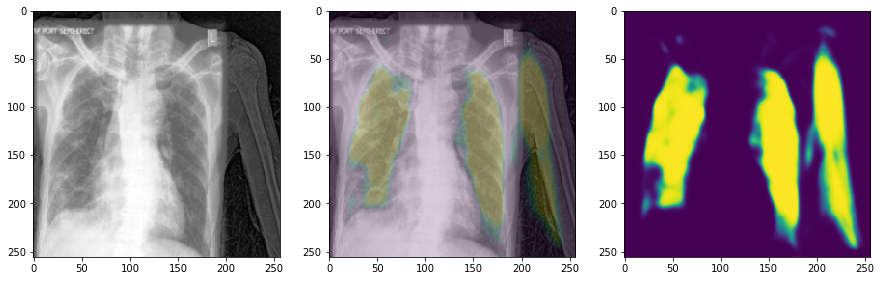

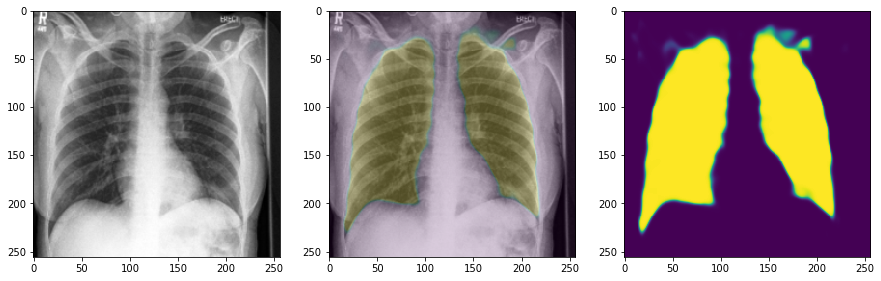

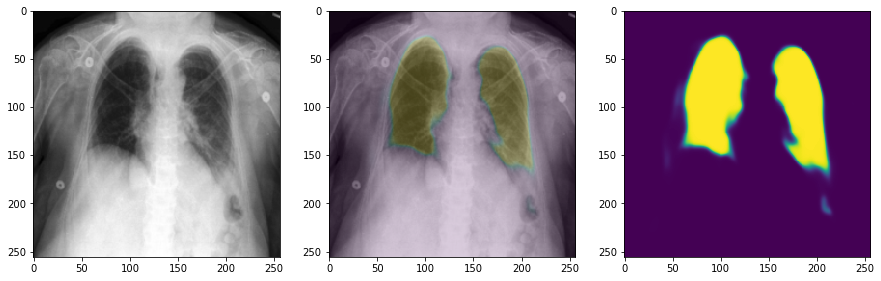

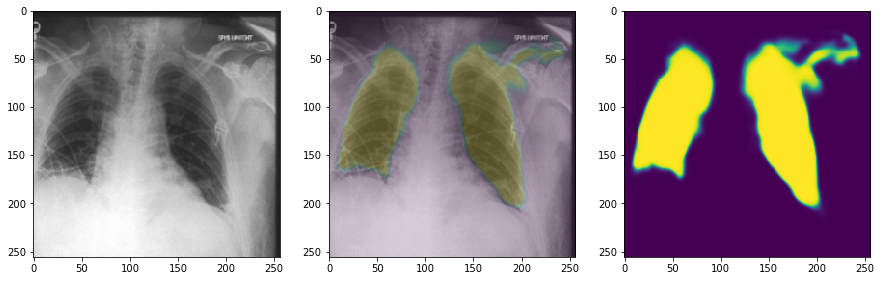

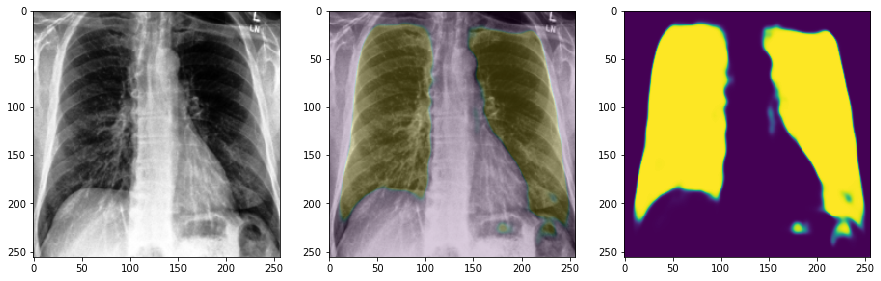

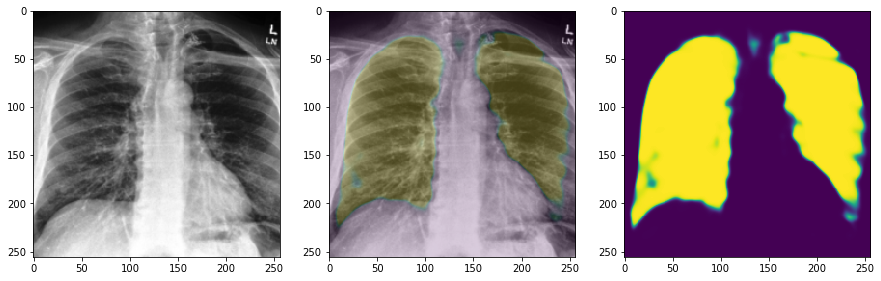

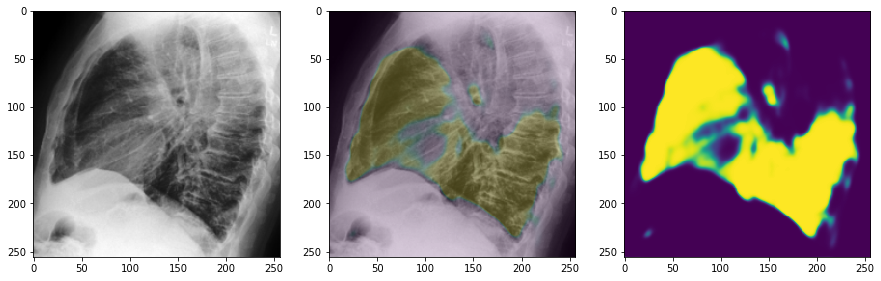

In [26]:
for i in range(3,10):
    fig = plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(xs[i,:,:,0], cmap='gray')
    plt.subplot(1,3,2)
    plt.imshow(xs[i,:,:,0], cmap='gray')
    plt.imshow(seg[i,:,:,0], alpha = 0.2)
    plt.subplot(1,3,3)
    plt.imshow(seg[i,:,:,0])
    plt.show()

# Test on MIMIC-CXR dataset

In [27]:
filename = '/ocean/projects/asc170022p/singla/Datasets/MIMIC-CXR/PA_AP_views_image_report_labels.csv'
df_mimic = pd.read_csv(filename)
print(df_mimic.shape)
df_mimic.head(1)

(215518, 24)


original_index                                Reports  No Finding  \
0               0  No acute cardiopulmonary abnormality.         1.0   

   Enlarged Cardiomediastinum  Cardiomegaly  Lung Lesion  Lung Opacity  Edema  \
0                         0.0           0.0          0.0           0.0    0.0   

   Consolidation  Pneumonia  ...  Fracture  Support Devices   study_id  \
0            0.0        0.0  ...       0.0              0.0  s53189527   

   subject_id                                   lateral_512_jpeg  \
0   p10000032  /ocean/projects/asc170022p/shared/Data/chestXR...   

                                              report ViewPosition StudyDate  \
0  /ocean/projects/asc170022p/shared/Data/chestXR...           PA       NaN   

  dicom_id train/valid  
0      NaN       train  

[1 rows x 24 columns]

In [28]:
from utils import load_images_and_labels
all_file_names = np.asarray(df_mimic['lateral_512_jpeg'])
xs = load_images_and_labels(all_file_names[0:10], 
                            image_dir='',
                            input_size=256,
                            crop_size=225,
                            num_channel=1,
                            normalize = True   )
[seg]  = sess.run([seg_x_source],  feed_dict={x_source: xs})
print(xs.shape, seg.shape)

10it [00:00, 239.77it/s]

((10, 256, 256, 1), (10, 256, 256, 1))


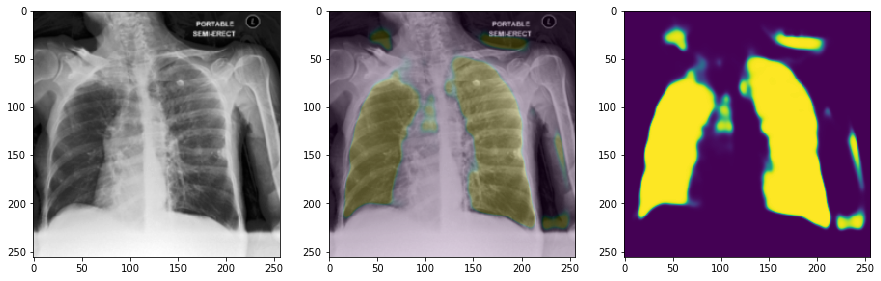

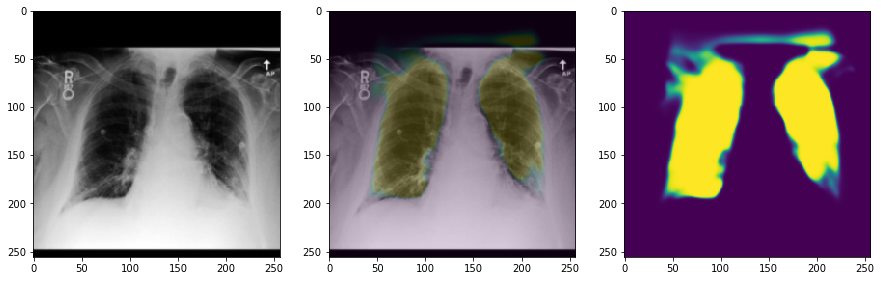

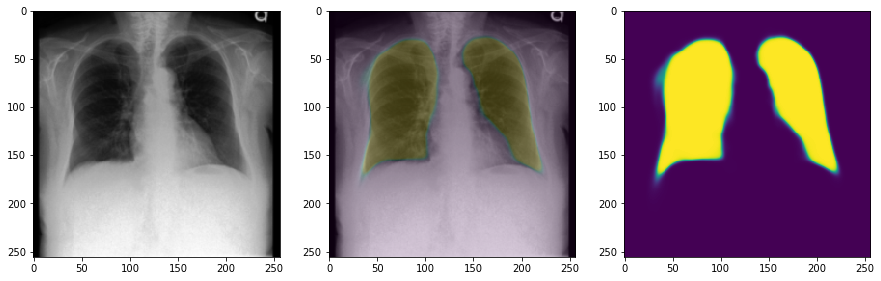

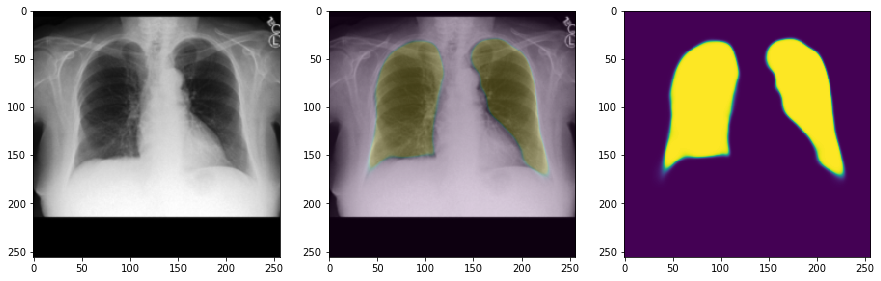

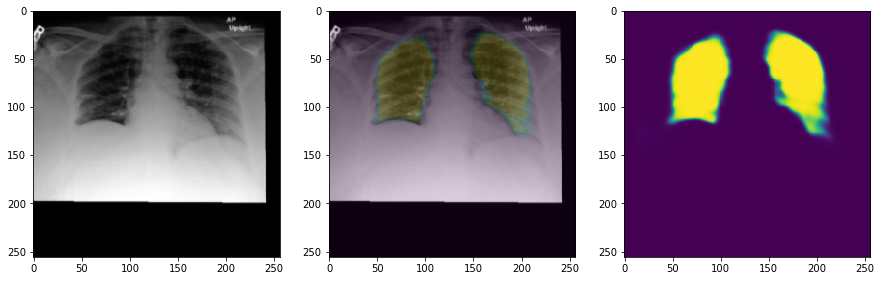

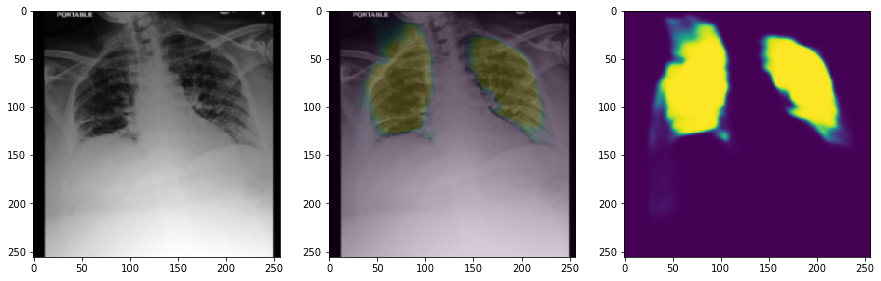

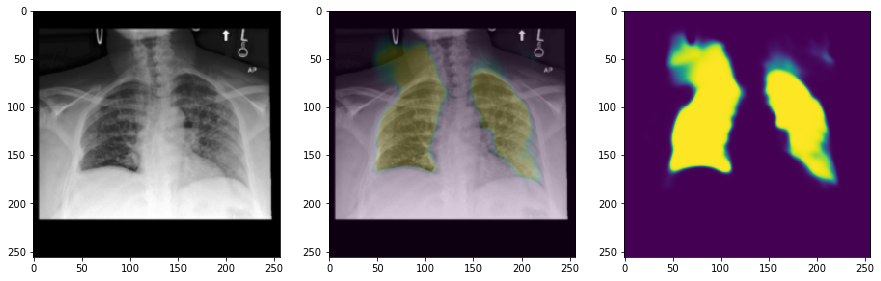

In [29]:
for i in range(3,10):
    fig = plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(xs[i,:,:,0], cmap='gray')
    plt.subplot(1,3,2)
    plt.imshow(xs[i,:,:,0], cmap='gray')
    plt.imshow(seg[i,:,:,0], alpha = 0.2)
    plt.subplot(1,3,3)
    plt.imshow(seg[i,:,:,0])
    plt.show()